# Boilerplate

In [1]:
from typing import Union
from allensdk.brain_observatory.ecephys.behavior_ecephys_session import BehaviorEcephysSession


from allensdk.brain_observatory.behavior.behavior_project_cache import (
    VisualBehaviorNeuropixelsProjectCache,
)
import brain_observatory_utilities.datasets.behavior.data_formatting as behavior_utils

import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import matplotlib.cm as cm
import seaborn as sns

from hmmlearn import hmm, vhmm
from sklearn.decomposition import PCA, KernelPCA, FactorAnalysis
from sklearn.preprocessing import StandardScaler

import utils

import warnings
warnings.filterwarnings("ignore")

# Random seed
SEED = 42

%matplotlib inline

In [2]:
cache_dir = utils.get_data_root()
cache = VisualBehaviorNeuropixelsProjectCache.from_local_cache(
    cache_dir=cache_dir, use_static_cache=True
)

In [3]:
ephys_table = cache.get_ecephys_session_table()
ephys_table = ephys_table.loc[(~ephys_table["behavior_session_id"].isna()) & 
                              (ephys_table["experience_level"] == "Familiar")
                             ]

In [4]:
# session_id = 1124507277
# session_id = 1069461581
# session = cache.get_ecephys_session(session_id)
session_ids = np.random.choice(ephys_table.index, 20)

# Defining Behavioral Metrics

In [9]:
%%time
parallel = True
if parallel:
    metrics = utils.parallel_session_map(utils.get_behavior_metrics, session_ids[10:], "ephys")
    metrics = [session[1] for session in metrics["sessions"]]
else:
    sessions = [cache.get_ecephys_session(session_id) for session_id in session_ids]
    metrics = [utils.get_behavior_metrics(session, center=True) for session in sessions]

Using 16 cores.
processing batch 1/1...
CPU times: user 2.43 s, sys: 1.57 s, total: 4 s
Wall time: 4min 20s


# HMM Model Fitting and Plotting

In [10]:
X = pd.concat(metrics)
X_lens = [len(x) for x in metrics]

In [11]:
def full_session_time(metric_df: pd.DataFrame) -> pd.DataFrame:
    t_steps = np.arange(metric_df.index.max() + 1)
    full_session = pd.DataFrame(index=t_steps, columns=metric_df.columns)
    full_session.loc[metric_df.index] = metric_df
    return full_session

In [12]:
startprob = np.array([.9, 0.1])
transmat = np.array([[0.99, 0.01],
                     [0.01, 0.99]
                    ])
model_2 = hmm.GaussianHMM(
    n_components=2, 
    n_iter=100000, 
    random_state=SEED, 
    init_params="m", 
    covariance_type="full", 
    startprob_prior=startprob,
    transmat_prior=transmat,
    covars_prior=X.cov().values,
    algorithm="map",
    implementation="scaling"
)

In [13]:
model_2.fit(X, X_lens);

In [32]:
metric_idx = 1

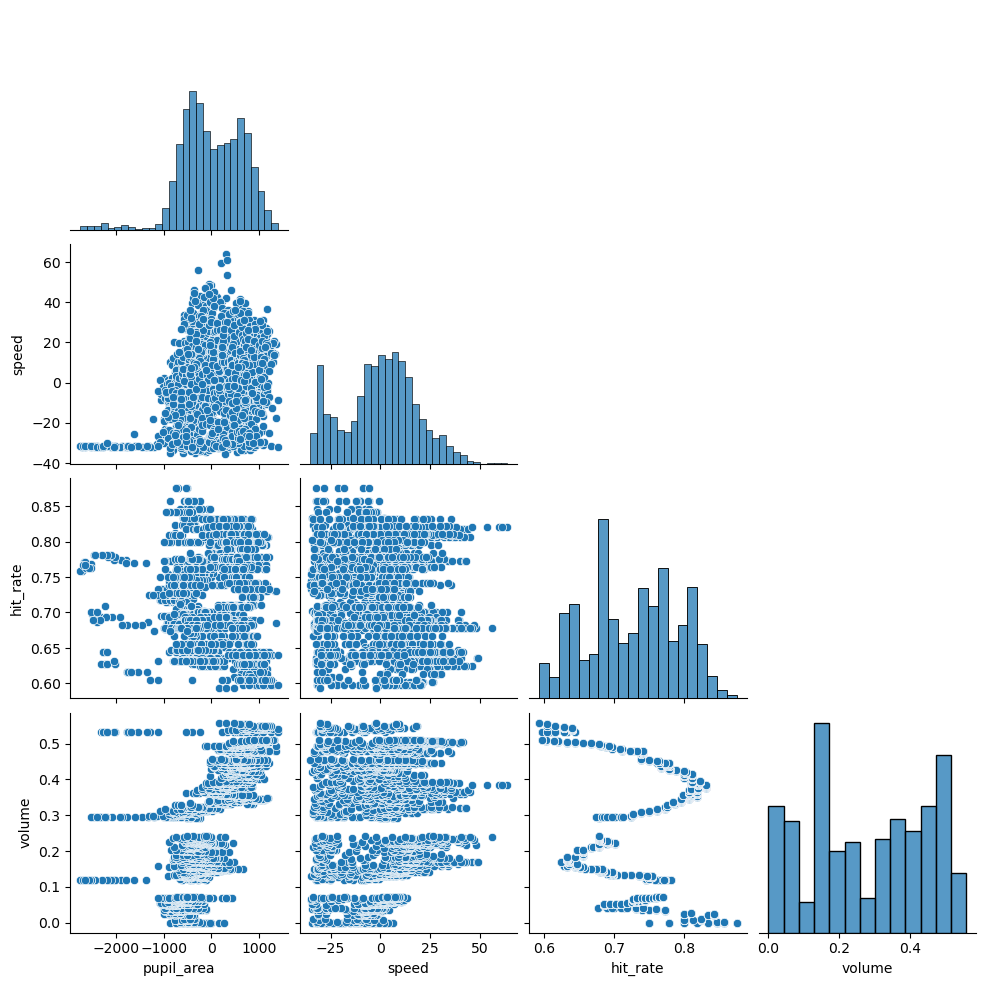

In [33]:
sns.pairplot(metrics[metric_idx], corner=True);

In [34]:
m_result_ = metrics[metric_idx].copy()
m_result_["state_2"] = model_2.predict(metrics[metric_idx])
m_result = full_session_time(m_result_)

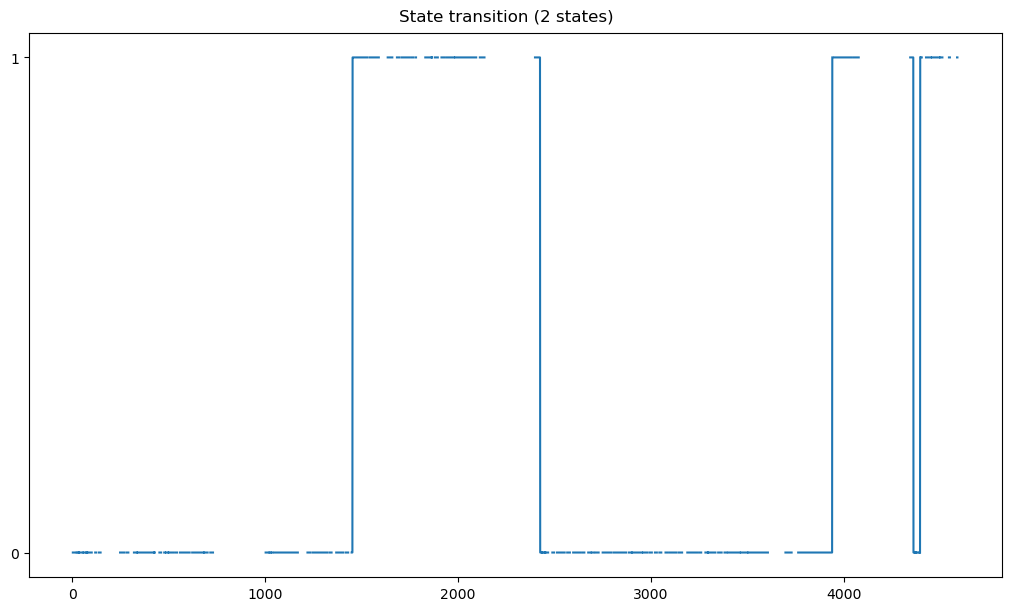

In [35]:
fig = plt.figure(constrained_layout=True, figsize=(10,6))
subfigs = fig.subfigures(nrows=1, ncols=1)
state = 2
subfigs.suptitle(f"State transition ({state} states)")
ax = subfigs.subplots()
ax.plot(np.arange(m_result.shape[0]),m_result[f"state_{state}"])
ax.set_yticks(np.arange(state), labels=np.arange(state).astype(str));

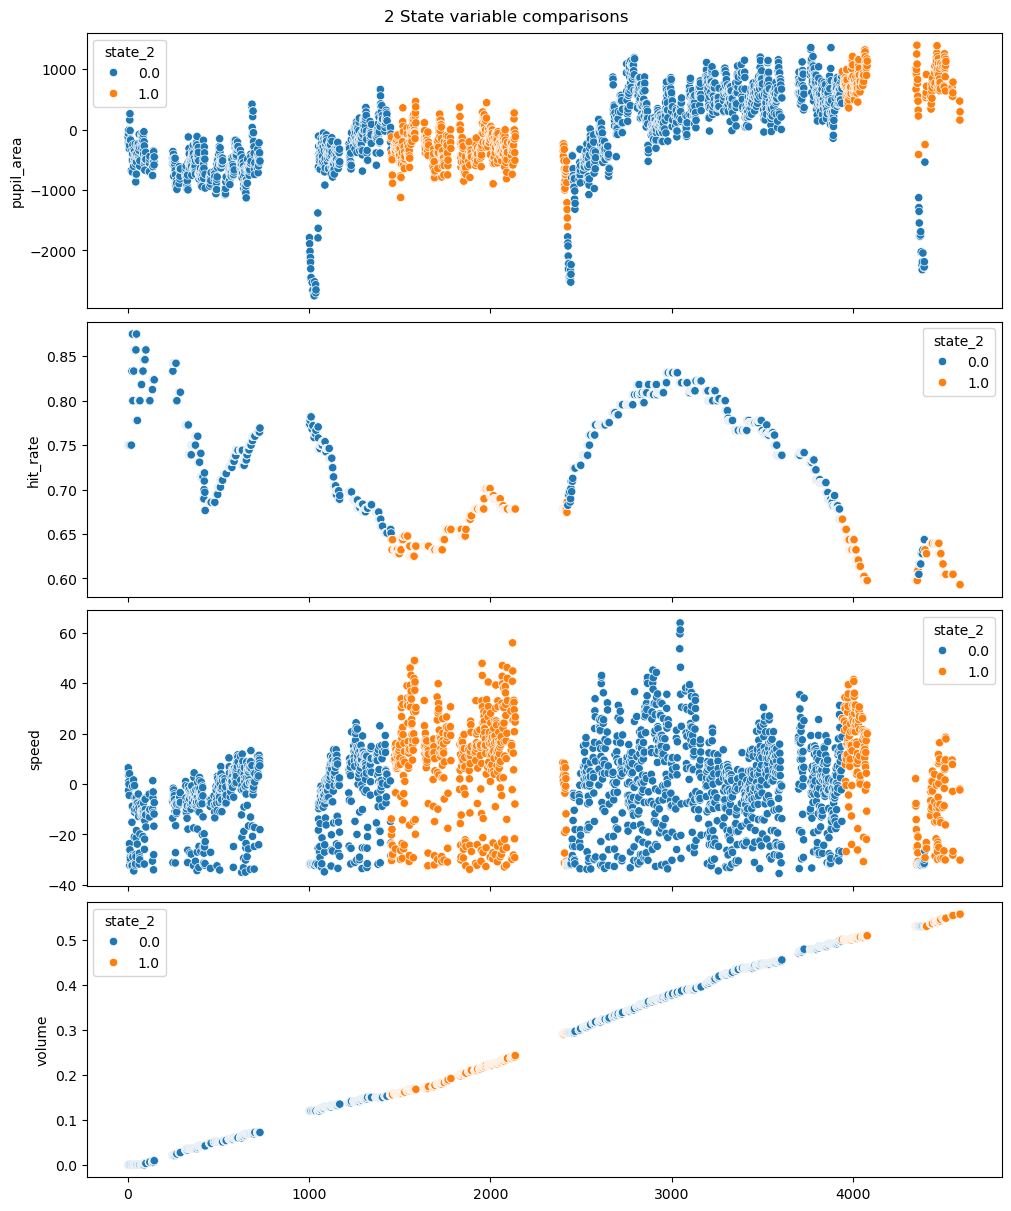

In [36]:
fig = plt.figure(constrained_layout=True, figsize=(10,12))
subfig = fig.subfigures(nrows=1, ncols=1)
state = 2
subfig.suptitle(f"{state} State variable comparisons")
axes = subfig.subplots(4, 1, sharex=True)

sns.scatterplot(
    m_result,
    x=np.arange(m_result.shape[0]),
    y="pupil_area",
    hue=m_result[f"state_{state}"], ax=axes[0])
sns.scatterplot(
    m_result,
    x=np.arange(m_result.shape[0]),
    y="hit_rate",
    hue=m_result[f"state_{state}"], ax=axes[1])
sns.scatterplot(
    m_result,
    x=np.arange(m_result.shape[0]),
    y="speed",
    hue=m_result[f"state_{state}"], ax=axes[2])
sns.scatterplot(
    m_result,
    x=np.arange(m_result.shape[0]),
    y="volume",
    hue=m_result[f"state_{state}"], ax=axes[3]);

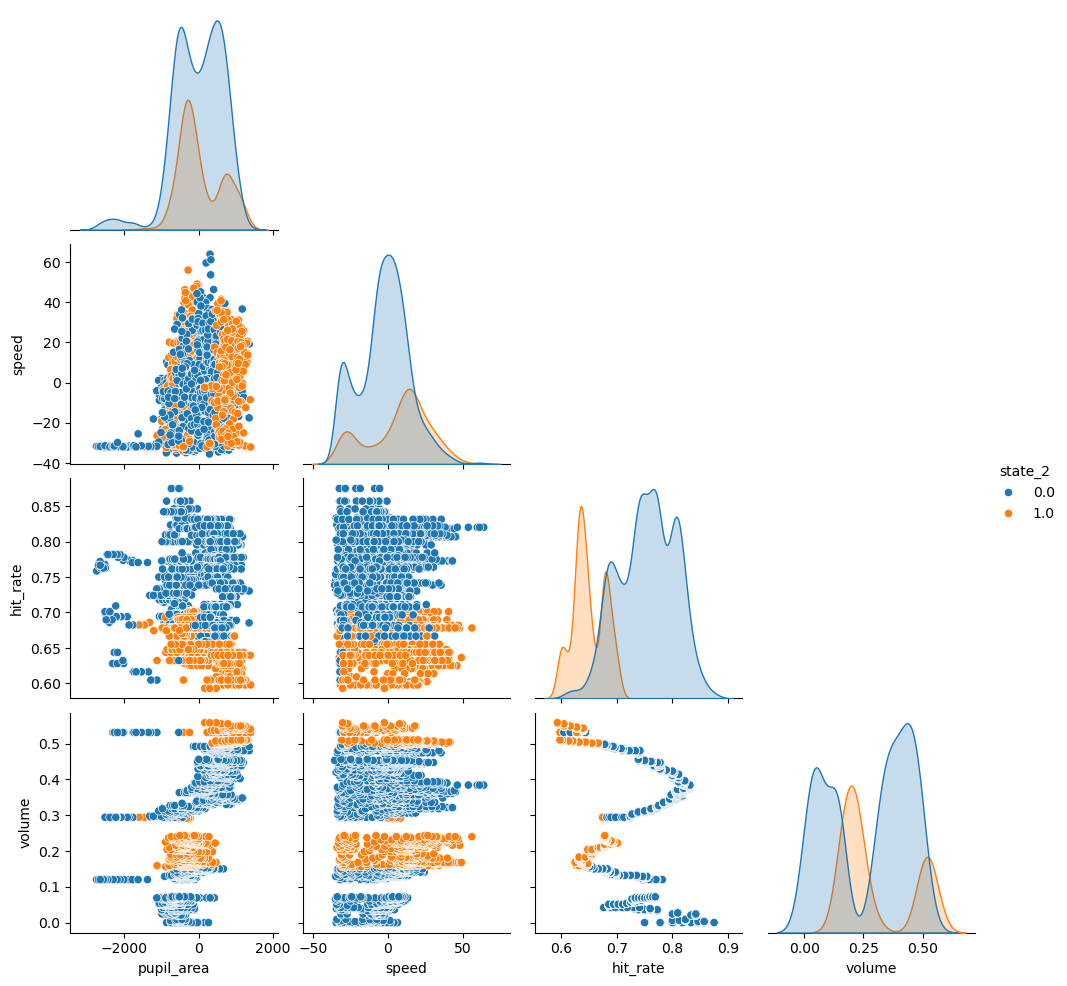

In [37]:
sns.pairplot(m_result, corner=True, hue="state_2");

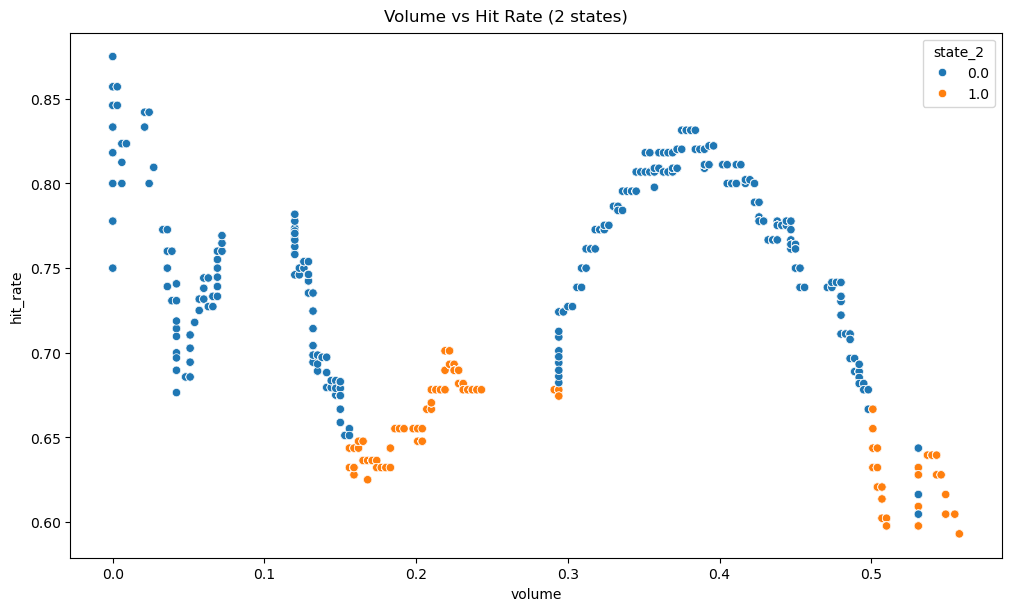

In [38]:
fig = plt.figure(constrained_layout=True, figsize=(10,6))
subfig = fig.subfigures(nrows=1, ncols=1)
state = 2
subfig.suptitle(f"Volume vs Hit Rate ({state} states)")
ax = subfig.subplots()
sns.scatterplot(m_result, x="volume", y="hit_rate", hue=m_result[f"state_{state}"], ax=ax);

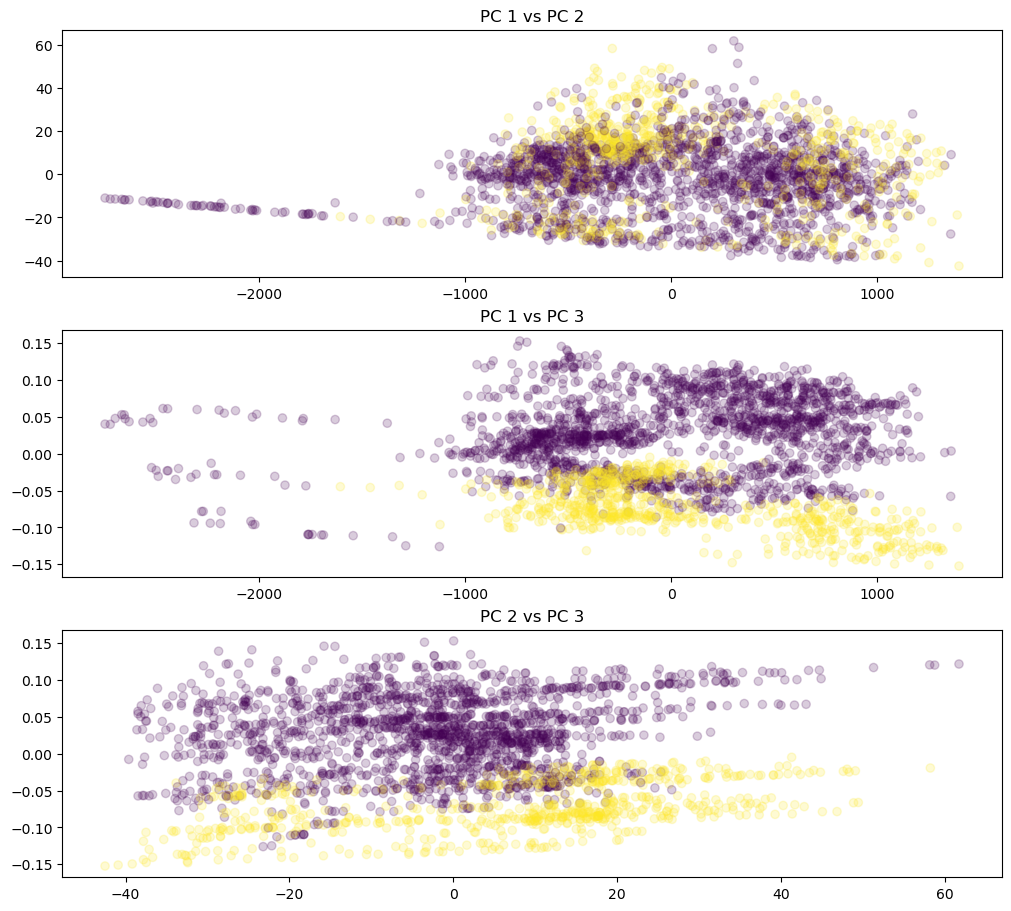

In [39]:
pca = PCA(n_components=3)
pca_m = m_result.loc[m_result.isna().sum(axis=1) == 0]
embeddings = pca.fit_transform(pca_m.drop(columns=["state_2", "volume"]))

fig = plt.figure(constrained_layout=True, figsize=(10,9))
subfig = fig.subfigures(nrows=1, ncols=1)
axes = subfig.subplots(3, 1)

axes[0].scatter(embeddings[:, 0], embeddings[:, 1], c=pca_m["state_2"], alpha=0.2)
axes[0].set_title("PC 1 vs PC 2")

axes[1].scatter(embeddings[:, 0], embeddings[:, 2], c=pca_m["state_2"], alpha=0.2)
axes[1].set_title("PC 1 vs PC 3");

axes[2].scatter(embeddings[:, 1], embeddings[:, 2], c=pca_m["state_2"], alpha=0.2)
axes[2].set_title("PC 2 vs PC 3");


# Getting Ephys Data

In [40]:
unit_table = cache.get_unit_table()

In [41]:
session = cache.get_ecephys_session(session_ids[metric_idx])

# Plotting data

In [44]:
rates, rates_df = utils.get_spike_rates(session)

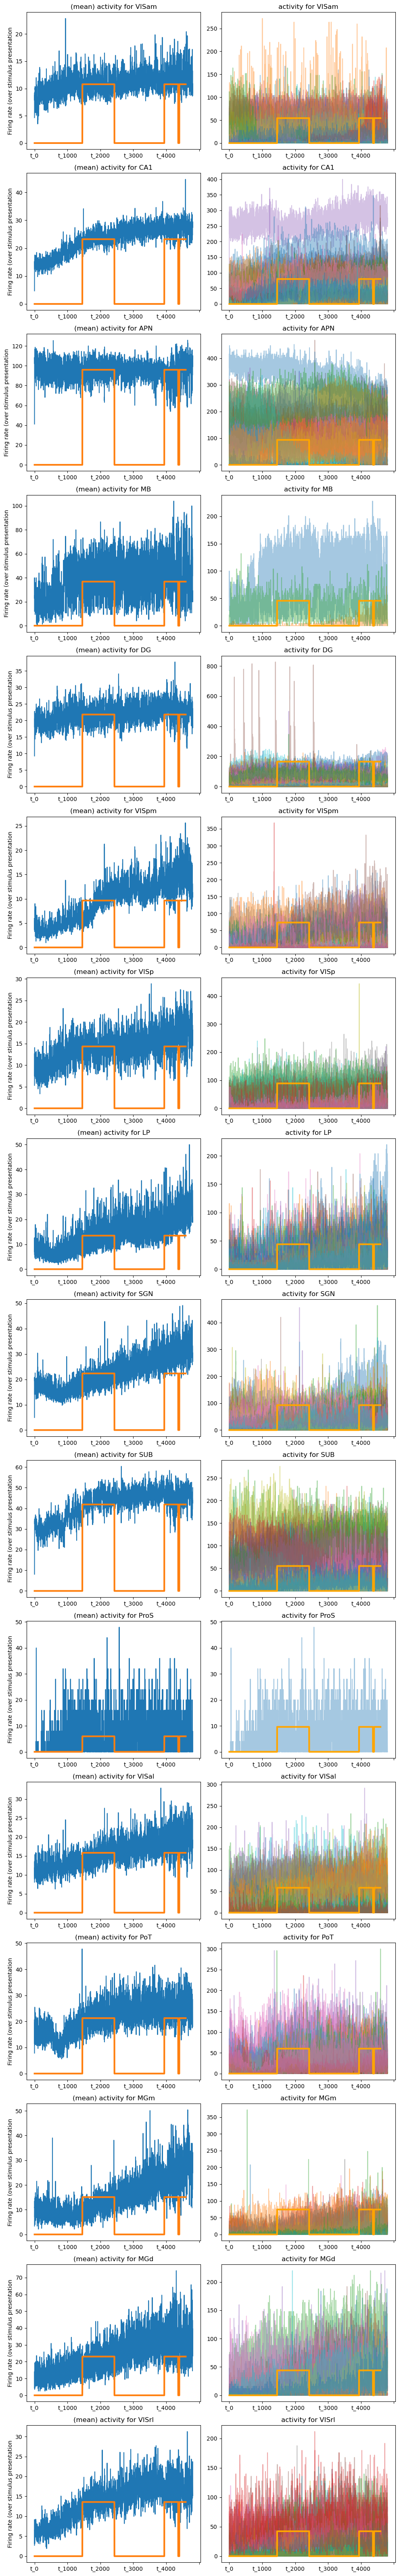

In [45]:
utils.plot_areas(rates_df, m_result_["state_2"]);

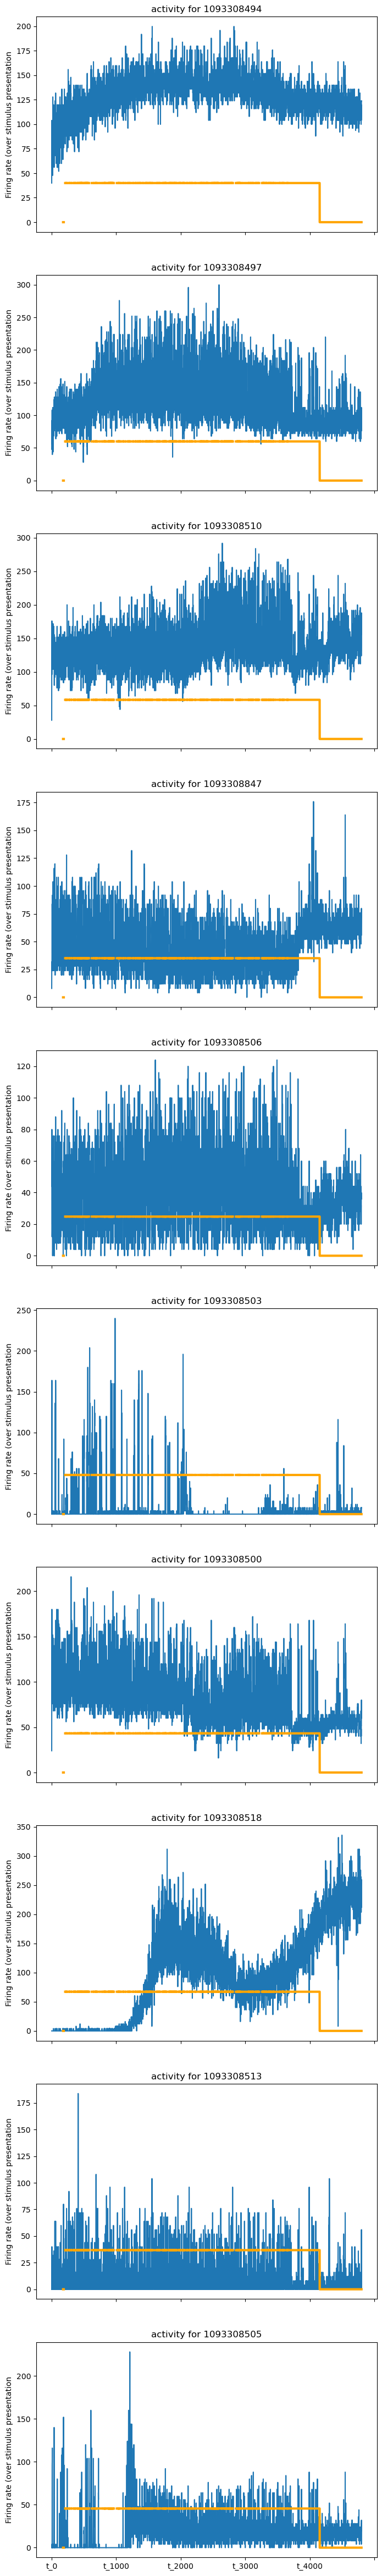

In [ ]:
utils.plot_area_units(rates_df, m_result["state_2"], "PIL");